In [ ]:
# !pip install git+https://github.com/Project-MONAI/MONAI#egg.gitmonai@0.8.1+271.g07de215c 
# !pip install nibabel==3.1.1
# !pip install tqdm==4.63.0
# !pip install itk==5.2.1.post
# !python -c "import matplotlib" || pip install -q matplotlib
# %matplotlib inline

In [19]:
import os
import shutil
import tempfile

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

from monai.losses import DiceCELoss
from monai.inferers import sliding_window_inference
from monai.transforms import (
    AsDiscrete,
    # AddChanneld,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandFlipd,
    RandCropByPosNegLabeld,
    RandShiftIntensityd,
    ScaleIntensityRanged,
    Spacingd,
    RandRotate90d,
    ToTensord,
)

from monai.config import print_config
from monai.metrics import DiceMetric
from monai.networks.nets import SwinUNETR

from monai.data import (
    DataLoader,
    CacheDataset,
    load_decathlon_datalist,
    decollate_batch,
)


import torch

import glob

In [4]:
root_dir = "../data/data_ct/train/"
train_images = sorted(glob.glob(os.path.join(root_dir, 'raw', "*.nii.gz")))
train_labels = sorted(glob.glob(os.path.join(root_dir, 'seg', "*.nii.gz")))

data_dicts = [{"image": images_name, "label": label_name} for images_name, label_name in zip(train_images, train_labels)]
train_files, val_files = data_dicts[:-9], data_dicts[-9:]

In [24]:
root_dir = "../data/data_ct/train/"
train_images = sorted(glob.glob(os.path.join(root_dir, 'raw', "*.nii.gz")))
train_labels = sorted(glob.glob(os.path.join(root_dir, 'seg', "*.nii.gz")))
train_images = train_images[:2]
train_labels = train_labels[:2]

data_dicts = [{"image": images_name, "label": label_name} for images_name, label_name in zip(train_images, train_labels)]
train_files, val_files = [data_dicts[0]], [data_dicts[1]]

In [19]:
root_dir = "../data/data_ct/train/"
train_images = sorted(glob.glob(os.path.join(root_dir, 'raw', "*.nii.gz")))
train_labels = sorted(glob.glob(os.path.join(root_dir, 'seg', "*.nii.gz")))
train_images = train_images[:10]
train_labels = train_labels[:10]

data_dicts = [{"image": images_name, "label": label_name} for images_name, label_name in zip(train_images, train_labels)]
train_files, val_files = data_dicts[:9], data_dicts[-1:]

In [25]:
import BMIC_Utils as bmu

new_train_files = []
new_val_files = []

for idx, file_name in enumerate(train_files):
    print(f"train: {idx}")
    image, _ = bmu.load_NII(file_name["image"], with_affine=True)
    image = image.astype(np.float32)
    image = np.expand_dims(image, axis=0)
    label, _ = bmu.load_NII(file_name["label"], with_affine=True)
    label = label.astype(np.float32)
    label = np.expand_dims(label, axis=0)
    
    new_train_files.append({"image": image, "label": label})


for idx, file_name in enumerate(val_files):
    print(f"val: {idx}")
    image = bmu.load_NII(file_name["image"], with_affine=False)
    image = image.astype(np.float32)
    image = np.expand_dims(image, axis=0)
    label = bmu.load_NII(file_name["label"], with_affine=False)
    label = label.astype(np.float32)
    label = np.expand_dims(label, axis=0)

    new_val_files.append({"image": image, "label": label})

train: 0
val: 0


In [26]:
train_transforms = Compose(
    [
        # LoadImaged(keys=["image", "label"]),
        # # AddChanneld(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="LPS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-1000,
            a_max=1000,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96, 96, 96),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[0],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[1],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[2],
            prob=0.10,
        ),
        RandRotate90d(
            keys=["image", "label"],
            prob=0.10,
            max_k=3,
        ),
        RandShiftIntensityd(
            keys=["image"],
            offsets=0.10,
            prob=0.50,
        ),
        ToTensord(keys=["image", "label"]),
    ]
)

val_transforms = Compose(
    [
        # LoadImaged(keys=["image", "label"]),
        # # AddChanneld(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="LPS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        ScaleIntensityRanged(
            keys=["image"], a_min=-1000, a_max=1000, b_min=0.0, b_max=1.0, clip=True
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        ToTensord(keys=["image", "label"]),
    ]
)

monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.


In [27]:
train_ds = CacheDataset(
    data=new_train_files,
    transform=train_transforms,
    cache_num=24,
    cache_rate=1.0,
    num_workers=8,
)
train_loader = DataLoader(
    train_ds, batch_size=1, shuffle=True, num_workers=8, pin_memory=True
)
val_ds = CacheDataset(
    data=new_val_files, 
    transform=val_transforms, 
    cache_num=6, 
    cache_rate=1.0, 
    num_workers=4
)
val_loader = DataLoader(
    val_ds, batch_size=1, shuffle=False, num_workers=4, pin_memory=True
)

`data_array` is not of type `MetaTensor, assuming affine to be identity.
Loading dataset:   0%|          | 0/1 [00:00<?, ?it/s]

Loading dataset: 100%|██████████| 1/1 [01:01<00:00, 61.67s/it]


In [20]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cuda:1"

In [21]:
model = SwinUNETR(
    img_size=(96, 96, 96),
    in_channels=1,
    out_channels=2,
    feature_size=48,
    use_checkpoint=True,
).to(device)

In [6]:
#Channge this while training in GPU
weight = torch.load("/scratch/scratch6/akansh12/challenges/parse2022/temp/model_swinvit.pt", map_location=torch.device('cpu'))
model.load_from(weights=weight)
print("Using pretrained self-supervied Swin UNETR backbone weights !")

Using pretrained self-supervied Swin UNETR backbone weights !


In [10]:
torch.backends.cudnn.benchmark = True
loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
root_dir = "./"

In [11]:
def validation(epoch_iterator_val):
    model.eval()
    with torch.no_grad():
        for step, batch in enumerate(epoch_iterator_val):
            val_inputs, val_labels = (batch["image"].to(device), batch["label"].to(device))
            val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, model)

            # print(f"V1: {val_inputs}")
            # print(f"V2: {val_outputs}")

            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [
                post_label(val_label_tensor) for val_label_tensor in val_labels_list
            ]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [
                post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list
            ]
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)
            epoch_iterator_val.set_description(
                "Validate (%d / %d Steps)" % (global_step, 10.0)
            )
        mean_dice_val = dice_metric.aggregate().item()
        dice_metric.reset()
    return mean_dice_val


def train(global_step, train_loader, dice_val_best, global_step_best):
    model.train()
    epoch_loss = 0
    step = 0
    epoch_iterator = tqdm(
        train_loader, desc="Training (X / X Steps) (loss=X.X)", dynamic_ncols=True
    )
    for step, batch in enumerate(epoch_iterator):
        step += 1
        x, y = (batch["image"].to(device), batch["label"].to(device))
        logit_map = model(x)
        loss = loss_function(logit_map, y)
        loss.backward()
        epoch_loss += loss.item()
        optimizer.step()
        optimizer.zero_grad()
        epoch_iterator.set_description(
            "Training (%d / %d Steps) (loss=%2.5f)"
            % (global_step, max_iterations, loss)
        )
        # if (
        #     global_step % eval_num == 0 and global_step != 0
        # ) or global_step == max_iterations:
        if True:
            epoch_iterator_val = tqdm(
                val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True
            )
            dice_val = validation(epoch_iterator_val)
            epoch_loss /= step
            epoch_loss_values.append(epoch_loss)
            metric_values.append(dice_val)
            print(dice_val)
            if dice_val > dice_val_best:
                dice_val_best = dice_val
                global_step_best = global_step
                torch.save(
                    model.state_dict(), os.path.join(root_dir, "best_metric_model_swin.pth")
                )
                print(
                    "Model Was Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )
            else:
                print(
                    "Model Was Not Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )
        global_step += 1
        
    return global_step, dice_val_best, global_step_best

In [28]:
val_inputs = None
val_outputs = None

In [12]:
max_iterations = 1
eval_num = 1
post_label = AsDiscrete(to_onehot=2)
post_pred = AsDiscrete(argmax=True, to_onehot=2)
dice_metric = DiceMetric(include_background=False, reduction="mean", get_not_nans=False)
global_step = 0
dice_val_best = 0.0
global_step_best = 0
epoch_loss_values = []
metric_values = []
while global_step < max_iterations:
    global_step, dice_val_best, global_step_best = train(
        global_step, train_loader, dice_val_best, global_step_best
    )
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model_swin.pth")))


Validate (0 / 10 Steps): 100%|██████████| 1/1 [00:19<00:00, 19.98s/it]?it/s]


0.0069292024709284306


Training (0 / 1 Steps) (loss=1.41185): 100%|██████████| 1/1 [01:45<00:00, 105.17s/it]

Model Was Saved ! Current Best Avg. Dice: 0.0069292024709284306 Current Avg. Dice: 0.0069292024709284306


<All keys matched successfully>

In [28]:
model.eval()
with torch.no_grad():
    epoch_iterator_val = tqdm(
        val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True
    )
    for step, batch in enumerate(epoch_iterator_val):
        val_inputs, val_labels = (batch["image"].to(device), batch["label"].to(device))
        val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, model)

Validate (X / X Steps) (dice=X.X): 100%|██████████| 1/1 [00:06<00:00,  6.06s/it]


### Results

In [ ]:
import matplotlib.pyplot as plt
epoch_loss_value = np.load("/scratch/scratch6/akansh12/challenges/parse2022/temp/train_epoch_loss_swin_unet_1000_hu_96.npy")
metric_value = np.load("/scratch/scratch6/akansh12/challenges/parse2022/temp/dice_swin_unet_1000_hu_96.npy")

plt.figure(figsize = (15,10))
plt.plot(epoch_loss_value, label = 'Train-Loss')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.figure(figsize = (15,10))
plt.plot(metric_value, label = 'Dice-VAL')
plt.legend()
plt.show()

### Evaluation

In [22]:
from collections import OrderedDict
path2model = "./weights_backup/best_metric_model_swin.pth"
state_dict = torch.load(path2model, map_location='cpu')
for keyA, keyB in zip(state_dict, model.state_dict()):
    state_dict = OrderedDict((keyB if k == keyA else k, v) for k, v in state_dict.items())
model.load_state_dict(state_dict)

<All keys matched successfully>

In [30]:
val_inputs = val_inputs.cpu().numpy()
val_labels = val_labels.cpu().numpy()
val_outputs = torch.argmax(val_outputs, dim=1).detach().cpu()

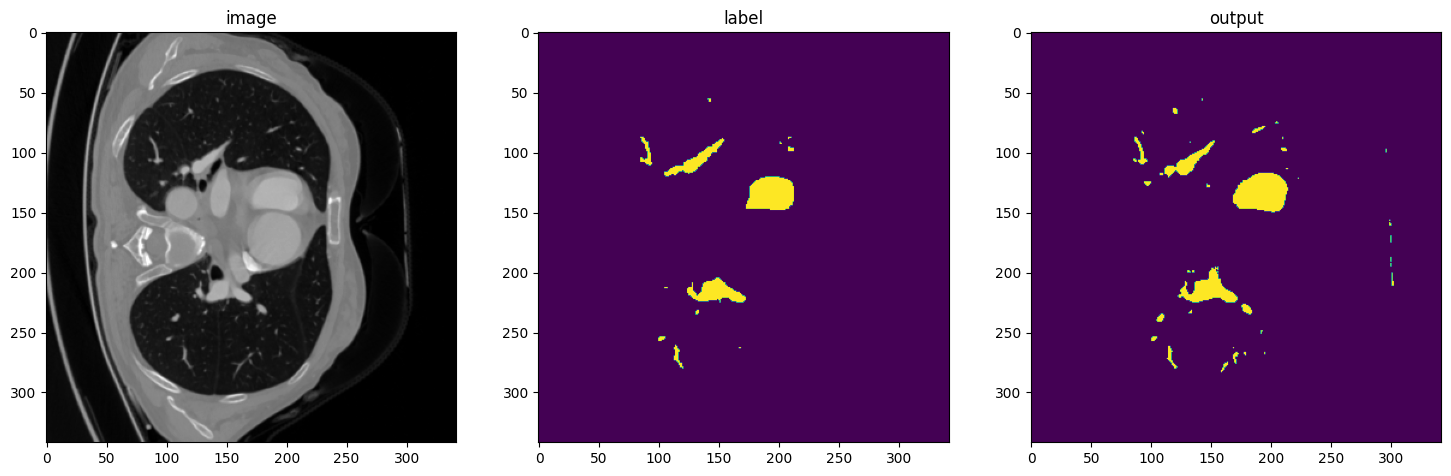

In [31]:
plt.figure("check", (18, 6))
plt.subplot(1, 3, 1)
plt.title("image")
plt.imshow(val_inputs[0, 0, :, :, 94], cmap="gray")
plt.subplot(1, 3, 2)
plt.title("label")
plt.imshow(val_labels[0, 0, :, :, 94])
plt.subplot(1, 3, 3)
plt.title("output")
plt.imshow(val_outputs[0, :, :, 94])
plt.show()

In [23]:
val_inputs = val_inputs.cpu().numpy()
val_labels = val_labels.cpu().numpy()
val_outputs = torch.argmax(val_outputs, dim=1).detach().cpu()

In [30]:
val_outputs.shape

torch.Size([1, 219, 172, 172])

Text(0.5, 1.0, 'Overlap')

<Figure size 2000x2000 with 0 Axes>

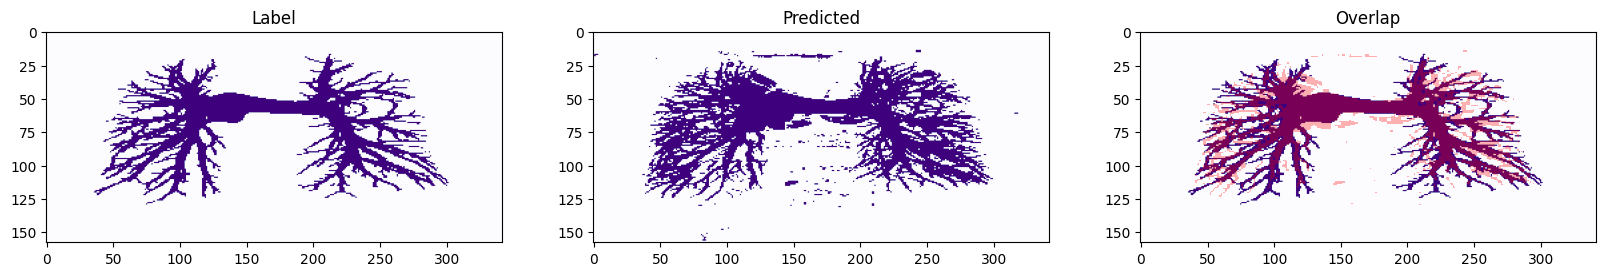

In [32]:
plt.figure(figsize=(20,20))
plt.figure(figsize=(20,20))
plt.subplot(1, 3, 1)
plt.imshow(np.rot90(val_labels[0][0].sum(axis = 1)>0), cmap = 'Purples')
plt.title("Label")
plt.subplot(1, 3, 2)
plt.imshow(np.rot90(val_outputs[0].sum(axis = 1)>0), cmap = 'Purples');
plt.title("Predicted")

plt.subplot(1, 3, 3)
plt.imshow(np.rot90(val_labels[0][0].sum(axis = 1)>0), cmap = 'Purples')
mask_ = np.ma.masked_where(val_outputs[0].sum(axis = 1) == 0, val_outputs[0].sum(axis = 1)>0)
plt.imshow(np.rot90(mask_), alpha=0.3, cmap = "autumn")
plt.title("Overlap")


### Swin Inference

In [5]:
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="LPS"),
        ScaleIntensityRanged(
            keys=["image"], a_min=-1000, a_max=1000, b_min=0.0, b_max=1.0, clip=True
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        ToTensord(keys=["image", "label"]),
    ]
)

val_ds = CacheDataset(
    data = val_files, transform = val_transforms,
    cache_rate = 1.0, num_workers = 4
)
val_loader = DataLoader(val_ds, batch_size = 1, shuffle = False, num_workers=4)


Loading dataset: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:37<00:00,  4.19s/it]


In [7]:
post_pred = Compose([AsDiscrete(argmax=True, to_onehot=2)])
post_label = Compose([AsDiscrete(to_onehot=2)])
dice_metric = DiceMetric(include_background=False, reduction="mean")

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SwinUNETR(
    img_size=(96, 96, 96),
    in_channels=1,
    out_channels=2,
    feature_size=48,
    use_checkpoint=True,
).to(device)

path2weights = "/scratch/scratch6/akansh12/challenges/parse2022/temp/Unet_1000_no_hu_spacing_192_augmentations_loss_ce.pth"
state_dict = torch.load(path2weights, map_location='cpu')

for keyA, keyB in zip(state_dict, model.state_dict()):
    state_dict = OrderedDict((keyB if k == keyA else k, v) for k, v in state_dict.items())
model.load_state_dict(state_dict)

In [ ]:
metric_values = []
model.eval()
with torch.no_grad():
    for index, val_data in enumerate(tqdm(val_loader)):

        val_inputs, val_labels = val_data['images'].to(device), val_data['labels'].to(device)
        roi_size = (256, 256, 256)
        sw_batch_size = 4
        val_outputs = sliding_window_inference(
                    val_inputs, roi_size, sw_batch_size, model)
        val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
        val_labels = [post_label(i) for i in decollate_batch(val_labels)]
        print(dice_metric(y_pred=val_outputs, y=val_labels))
        

    metric = dice_metric.aggregate().item()
    dice_metric.reset()
print(metric)